In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

import multiprocessing
from multiprocessing import Pool

import rider

import time
import ipdb
from IPython import display

%matplotlib inline

# Load data, Chicago road network
Source: [https://tzin.bgu.ac.il/~bargera/tntp/](https://tzin.bgu.ac.il/~bargera/tntp/)

In [2]:
nodes_org = pd.read_csv('./data/Chicago/node.csv')
nodes_org['x'] = (nodes_org['x'] - nodes_org['x'].min()) * 0.0003048
nodes_org['y'] = (nodes_org['y'] - nodes_org['y'].min()) * 0.0003048

edges_org = pd.read_csv('./data/Chicago/edge.csv')
    

## Zoom in the map

In [3]:
def filter_map(nodes, edges, x_min, x_max):
    y_min, y_max = x_min, x_max
    nodes = nodes.loc[(nodes['x']>x_min) & (nodes['x']<x_max)]
    nodes = nodes.loc[(nodes['y']>y_min) & (nodes['y']<y_max)]
    nodes.index = range(nodes.shape[0])
    
    new_edges = pd.DataFrame([], columns=edges.columns)
    node_list = list(nodes['NodeName'])
    for i in edges.index:
        if edges.loc[i, 'from'] in node_list and edges.loc[i, 'to'] in node_list:
            new_edges.loc[i] = edges.loc[i]
    new_edges.index = range(new_edges.shape[0])
    
    new_nodes = pd.DataFrame([], columns=nodes.columns)
    for i in nodes.index:
        if nodes.loc[i, 'NodeName'] in list(new_edges['from']) or nodes.loc[i, 'NodeName'] in list(new_edges['to']):
            new_nodes.loc[i] = nodes.loc[i]
    new_nodes.index = range(new_nodes.shape[0])
    new_nodes['NodeName'] = new_nodes['NodeName'].astype(int)
    
    return new_nodes, new_edges


In [4]:
nodes, edges = filter_map(nodes_org, edges_org, 97, 107)
nodes['x'] = nodes['x'] - nodes['x'].min()
nodes['y'] = nodes['y'] - nodes['y'].min()

In [5]:
edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.linalg.norm(from_node[['x', 'y']].values.flatten() - to_node[['x', 'y']].values.flatten())

## Treat the map as a weighted graph
Distance is the link weight

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

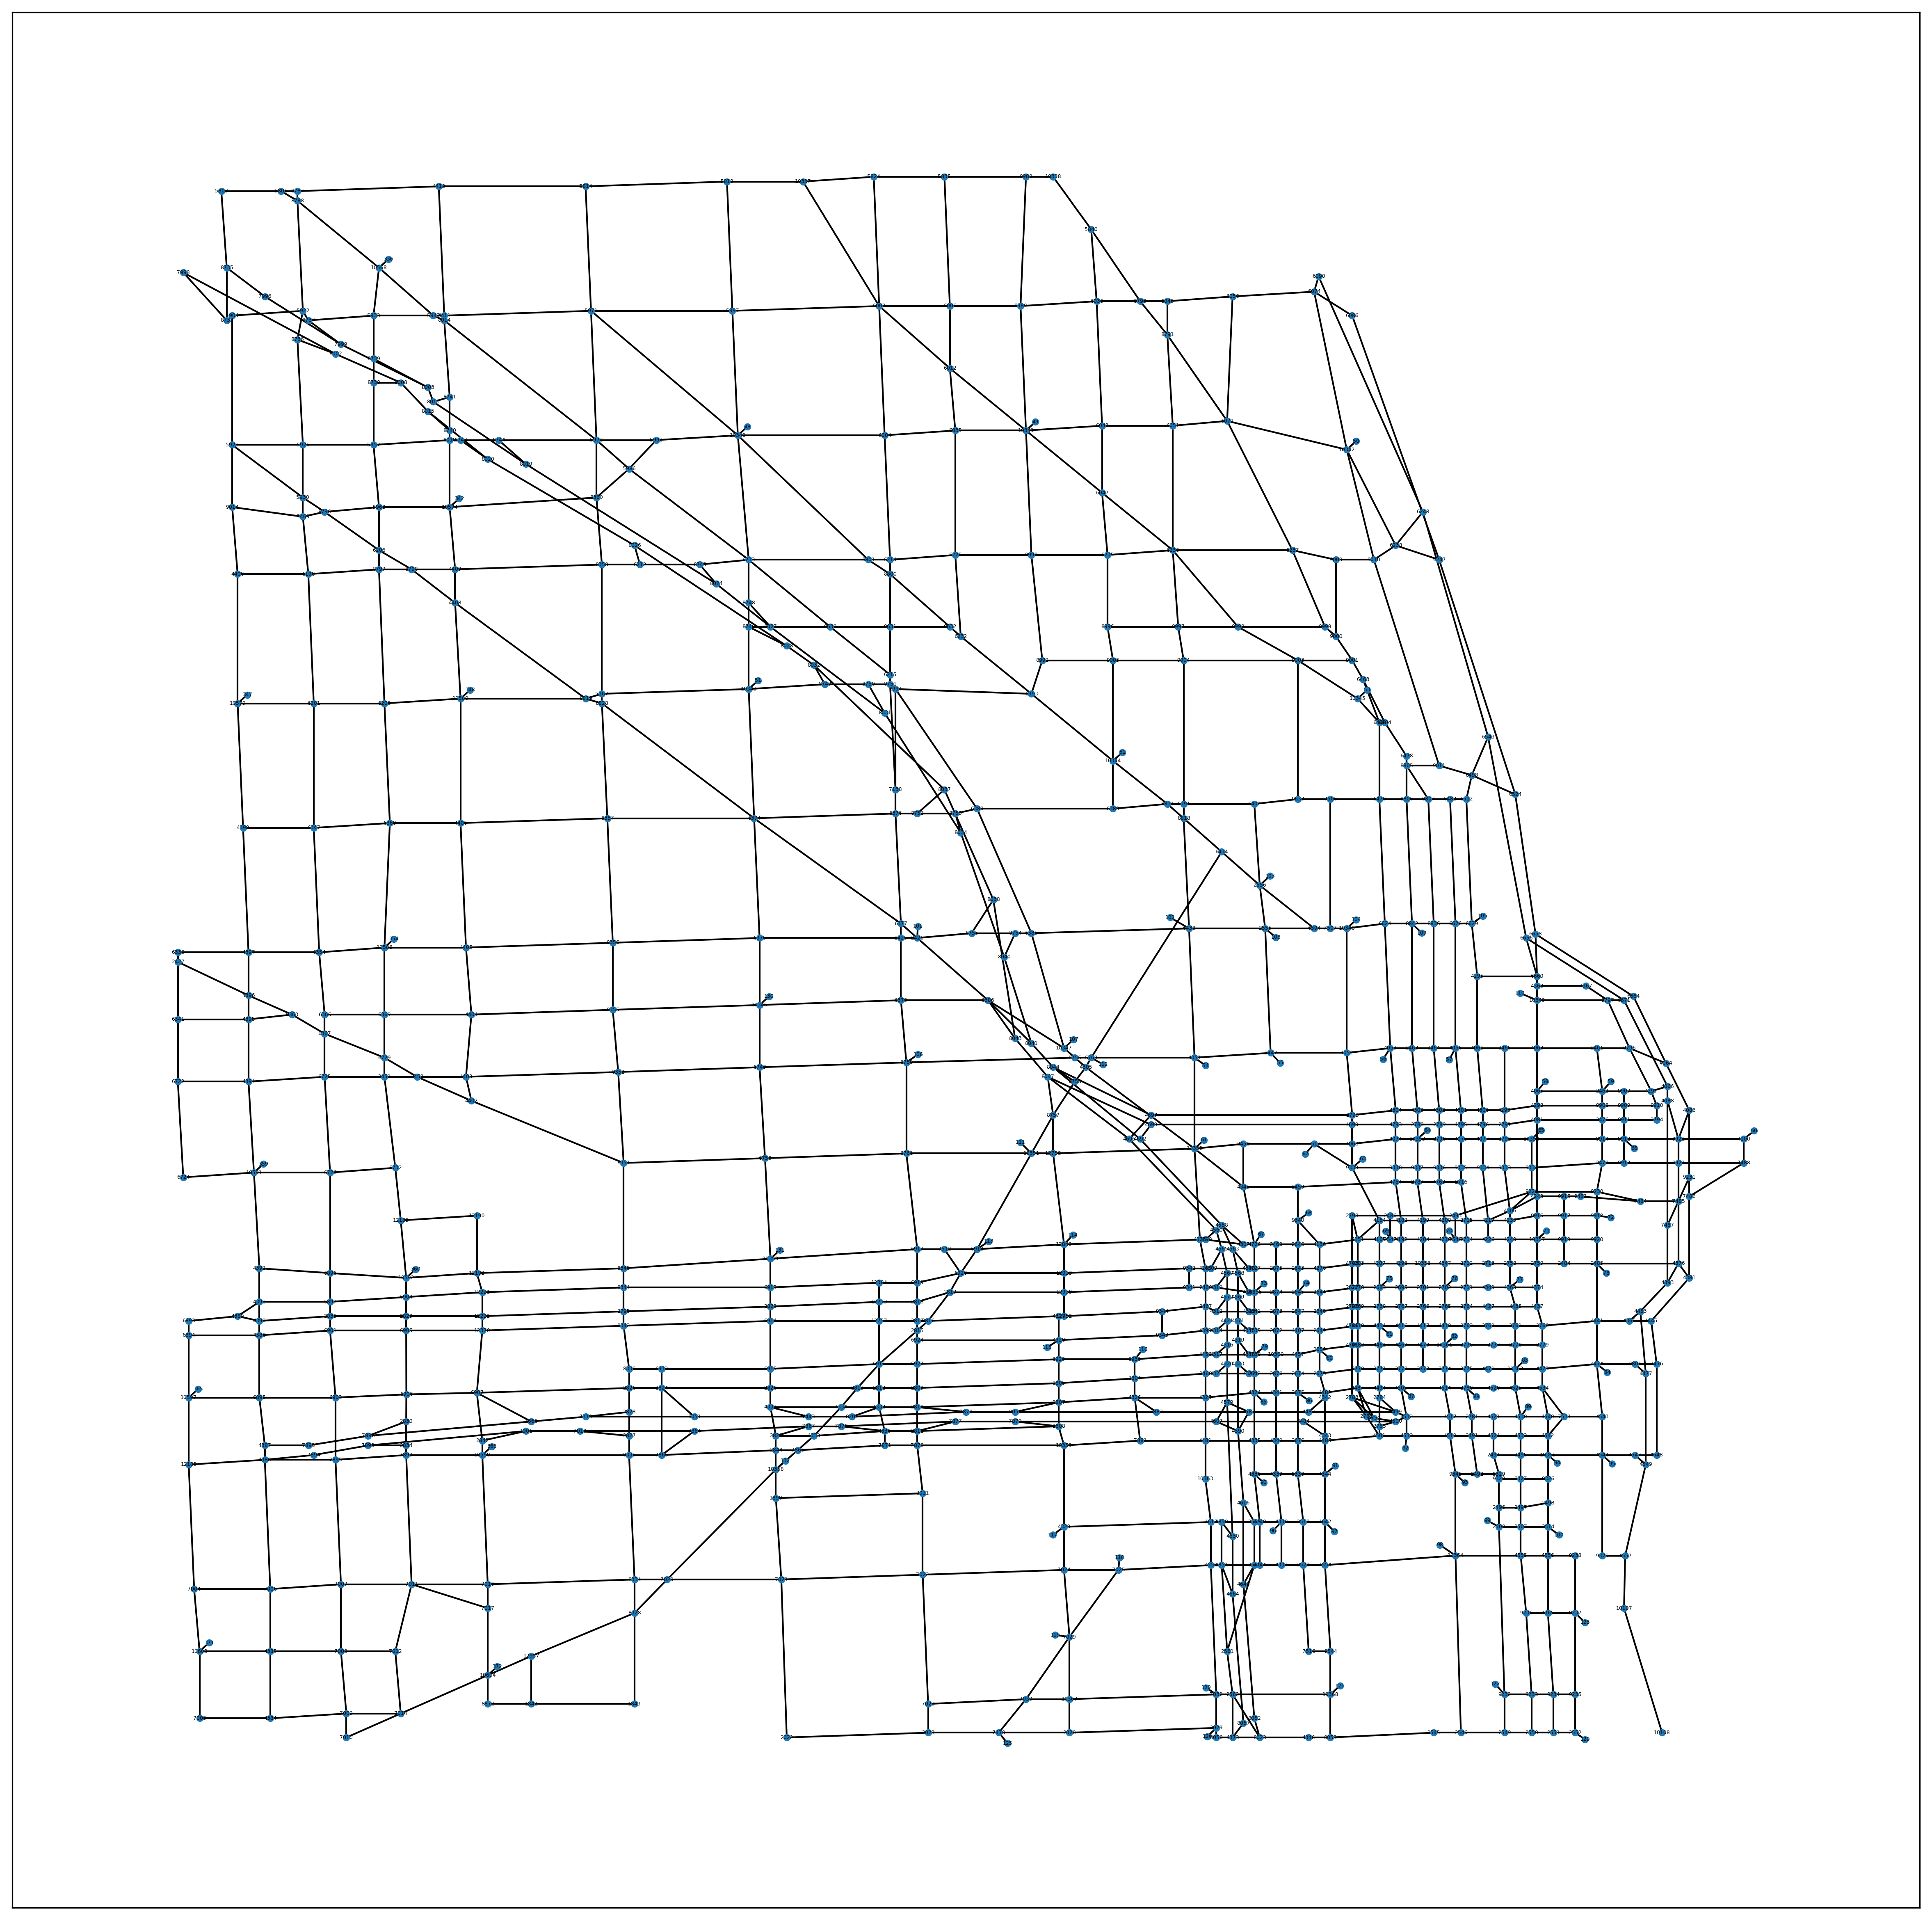

In [7]:
plt.figure(figsize=[20,20], dpi=300)
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos, font_size=3, node_size=10)

Try Dijkstra method

In [8]:
nx.dijkstra_path(G, 5933, 2766)

[5933,
 8739,
 8003,
 8011,
 8019,
 8024,
 8027,
 8031,
 8034,
 8040,
 8041,
 8044,
 4692,
 4558,
 4563,
 4568,
 4311,
 10355,
 2641,
 2873,
 2647,
 2648,
 2769,
 2768,
 2767,
 2766]

# Define rider

## Rider attributes

|Attributes|Type|Note|
|---|---|---|
|ID|int|specified, unchanged, equals the index of rider_set|
|position|1D array|updated on every move|
|state|string|'idle', 'working' or 'stop'|
|speed|int|maxspeed when working, half maxspeed when idle|
|maxspeed|int|specified, unchanged|
|stop_time|float|0 when moving, increase when stop|
|total_time|float|count from matched (start working)|
|total_time_rec|list|record of total_time|
|next_node|int|determined by path or randomly chosen|
|nextnext_node|int|determined by path or randomly chosen|
|destination|int|can be merchant_node or customer_node, is None when idle|
|path|list|obtained by dijkstra method, is None when idle|
|closest_merchant_node|int|the closest merchant node ID (by distance)|
|merchant_node|int|is the closest merchant when working, is None when idle|
|merchant_node_set|int|set of all merchant nodes, unchanged|
|customer_nodes|list|updated on every arrival of destinations|
|matched_orders|list|updated on every arrival of destinations|
|if_matched|boolean|if the rider is matched, randomly chosen by the platform|
|if_matchable|boolean|if the rider lies in the matching area, it is matchable|
|dec_var|dict|contains r cR k t N q_bar|


## Rider behaviors
|Behaviors|Note|
|---|---|
|||

# Define platform


In [9]:
class platform:
    def __init__(self, r, cR, k, t):
        self.accumulated_order = []
        self.num_accumulated_order = 0
        self.accumulated_order_which_merchant = []
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def check_order_distance(self, generated_orders):
        # if the order is not at any of the merchant's delivery distance,
        # then remove this order
        
        to_be_removed_orders = []
        for i in generated_orders:
            for j in merchant_node_set:
                if np.linalg.norm(rider.get_node_xy(i) - rider.get_node_xy(j)) > self.cR:
                    try:
                        generated_orders.remove(i)
                    except:
                        None
        return generated_orders
        
    def acquire_order(self, q):
        num_generated_order_c = np.random.rand() * q * t_resolution * 2  # this is continuous ('_c'), not descrete
        self.num_accumulated_order += num_generated_order_c
        
        num_generated_order = int(self.num_accumulated_order - len(self.accumulated_order))
        
        generated_orders = list(np.random.choice(list(nodes['NodeName']), size=num_generated_order, replace=False))
        generated_orders = self.check_order_distance(generated_orders)
        self.accumulated_order.extend(generated_orders)

        generated_orders_which_merchant = [
            rider.get_closest_node(rider.get_node_xy(i), merchant_node_set) for i in generated_orders
        ]
        self.accumulated_order_which_merchant.extend(generated_orders_which_merchant)
    
    def remove_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            ind = self.accumulated_order.index(i)
            self.accumulated_order.remove(i)
            self.accumulated_order_which_merchant.remove(self.accumulated_order_which_merchant[ind])
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            acc_ord_this_mer = np.array(self.accumulated_order)[np.array(self.accumulated_order_which_merchant)==merchant_node]
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )

            matched_rider_IDs_this_merchant = list(np.random.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))
            
            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)

            
            self.remove_matched_order(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)
        
        self.matched_batches = matched_batches
        
        return np.array(matched_batches), matched_rider_IDs  # their indexes are mutually matched
        

In [10]:
# Multi processing, but it is slower if only step one pace forward
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=rider.move_rider, iterable=params )
    return moved_rider_set


In [11]:
config_set = []
rider_set = []
N = 2000
q_bar = 2000
r = 5
cR = 5
k = 3
t = 0.02

Delta = cR
t_resolution = 0.005
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = [10343, 2766]

n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

In [12]:
for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.rand()*nodes['x'].max(), np.random.rand()*nodes['y'].max()]),
        'maxspeed': np.random.randint(10, 20)
    }
    rider_i = rider.rider(config_i, dec_var, merchant_node_set)
    
    config_set.append(config_i)
    rider_set.append(rider_i)

In [13]:
virtual_plat = platform(r, cR, k, t)

In [14]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []

rider 95 completed! time:1.89
rider 1668 completed! time:0.94
rider 803 completed! time:1.21
rider 1789 completed! time:0.82
rider 1251 completed! time:1.99
rider 1530 completed! time:1.11
rider 1743 completed! time:1.31
rider 109 completed! time:0.97
rider 1016 completed! time:1.54
rider 1931 completed! time:0.86
rider 847 completed! time:1.05
rider 719 completed! time:0.93
rider 365 completed! time:0.81
rider 965 completed! time:1.02
rider 1839 completed! time:1.21
rider 745 completed! time:1.16
rider 986 completed! time:1.18
rider 1320 completed! time:0.91
rider 1075 completed! time:1.15
rider 1065 completed! time:0.76
rider 1872 completed! time:0.99
rider 1368 completed! time:1.91
rider 387 completed! time:1.51
rider 793 completed! time:2.36
rider 1102 completed! time:1.73
rider 1247 completed! time:1.29
rider 607 completed! time:1.00
rider 828 completed! time:1.72
rider 871 completed! time:1.00
rider 772 completed! time:1.03
rider 326 completed! time:0.98
rider 869 completed! time

Process SpawnPoolWorker-6:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    s

 time:1.33
rider 991 completed! time:1.32
rider 1816 completed! time:0.92
rider 1949 completed! time:1.23
rider 1366 completed! time:0.82
rider 437 completed! time:2.00
rider 1284 completed! time:1.12
rider 1088 completed! time:1.07
rider 1199 completed! time:1.02
rider 143 completed! time:0.97
rider 28 completed! time:0.74
rider 156 completed! time:1.08
rider 750 completed! time:1.07
rider 997 completed! time:1.03
rider 1121 completed! time:0.96
rider 1585 completed! time:1.06
rider 1640 completed! time:0.80
rider 500 completed! time:0.85
rider 950 completed! time:0.94
rider 890 completed! time:0.91
rider 1263 completed! time:0.97
rider 1597 completed! time:1.10
rider 12 completed! time:0.76
rider 623 completed! time:0.96
rider 742 completed! time:1.24
rider 970 completed! time:0.99
rider 1556 completed! time:1.25
rider 30 completed! time:1.77
rider 190 completed! time:1.05
rider 1573 completed! time:1.19
rider 490 completed! time:2.05
rider 1224 completed! time:1.25
rider 922 complet

rider 755 completed! time:1.05
rider 279 completed! time:1.30
rider 994 completed! time:1.37
rider 51 completed! time:1.24
rider 1211 completed! time:1.10
rider 913 completed! time:0.70
rider 804 completed! time:1.46
rider 906 completed! time:1.16
rider 814 completed! time:1.59
rider 885 completed! time:1.09
rider 1025 completed! time:1.40
rider 1318 completed! time:0.82
rider 1462 completed! time:0.92
rider 1492 completed! time:1.05
rider 79 completed! time:1.09
rider 1143 completed! time:1.23
rider 1088 completed! time:1.03
rider 1150 completed! time:1.35
rider 1244 completed! time:1.00
rider 1029 completed! time:1.49
rider 811 completed! time:0.97
rider 817 completed! time:0.91
rider 754 completed! time:1.06
rider 755 completed! time:0.95
rider 1595 completed! time:1.05
rider 1296 completed! time:1.43
rider 1446 completed! time:0.74
rider 165 completed! time:1.15
rider 1348 completed! time:1.08
rider 1390 completed! time:1.58
rider 759 completed! time:0.81
rider 1766 completed! time

rider 1307 completed! time:1.39
rider 1523 completed! time:0.78
rider 1613 completed! time:1.18
rider 517 completed! time:0.95
rider 52 completed! time:0.76
rider 369 completed! time:1.06
rider 479 completed! time:1.26
rider 1429 completed! time:2.25
rider 1726 completed! time:1.08
rider 1590 completed! time:1.25
rider 1865 completed! time:0.93
rider 1877 completed! time:0.99
rider 1790 completed! time:0.99
rider 1986 completed! time:0.89
rider 1191 completed! time:0.90
rider 1392 completed! time:1.44
rider 1457 completed! time:2.10
rider 429 completed! time:2.00
rider 951 completed! time:0.91
rider 654 completed! time:1.30
rider 583 completed! time:2.23
rider 1519 completed! time:0.95
rider 1688 completed! time:1.24
rider 1982 completed! time:1.03
rider 1409 completed! time:1.36
rider 1299 completed! time:1.00
rider 1489 completed! time:0.70
rider 336 completed! time:0.86
rider 1897 completed! time:1.63
rider 1983 completed! time:1.05
rider 500 completed! time:1.49
rider 1112 complete

rider 857 completed! time:1.04
rider 1347 completed! time:0.92
rider 328 completed! time:0.97
rider 382 completed! time:1.09
rider 415 completed! time:1.11
rider 486 completed! time:1.39
rider 642 completed! time:1.37
rider 562 completed! time:1.03
rider 62 completed! time:1.25
rider 265 completed! time:1.69
rider 273 completed! time:1.23
rider 574 completed! time:1.35
rider 1660 completed! time:1.00
rider 390 completed! time:0.99
rider 1811 completed! time:0.84
rider 1169 completed! time:0.95
rider 80 completed! time:1.43
rider 1845 completed! time:1.01
rider 419 completed! time:0.94
rider 1925 completed! time:1.18
rider 598 completed! time:1.13
rider 1537 completed! time:1.82
rider 824 completed! time:1.41
rider 1470 completed! time:0.96
rider 1582 completed! time:1.21
rider 1751 completed! time:1.25
rider 1818 completed! time:0.84
rider 1790 completed! time:1.23
rider 1807 completed! time:1.23
rider 357 completed! time:1.24
rider 461 completed! time:1.26
rider 1024 completed! time:0

Process SpawnPoolWorker-5:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


time:1.32
rider 1947 completed! time:1.43
rider 879 completed! time:1.92
rider 1959 completed! time:0.96
rider 1824 completed! time:1.02
rider 1736 completed! time:1.02
rider 1365 completed! time:1.16
rider 731 completed! time:1.40
rider 450 completed! time:1.43
rider 168 completed! time:0.96
rider 306 completed! time:0.96
rider 1592 completed! time:1.18
rider 1124 completed! time:0.92
rider 1372 completed! time:2.34
rider 580 completed! time:1.07
rider 1598 completed! time:1.18
rider 1706 completed! time:1.30
rider 1078 completed! time:1.60
rider 1524 completed! time:1.11
rider 1615 completed! time:1.53
rider 1684 completed! time:1.25
rider 681 completed! time:0.75
rider 7 completed! time:2.40
rider 1511 completed! time:1.19
rider 284 completed! time:1.08
rider 1343 completed! time:1.85
rider 1351 completed! time:0.95
rider 1298 completed! time:1.09
rider 1240 completed! time:1.20
rider 533 completed! time:0.97
rider 872 completed! time:1.45
rider 658 completed! time:1.42
rider 1401 c

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    s


rider 752 completed! time:0.82
rider 740 completed! time:1.66
rider 1062 completed! time:1.13
rider 1983 completed! time:1.25
rider 942 completed! time:0.98
rider 872 completed! time:1.03
rider 845 completed! time:1.24
rider 1511 completed! time:1.06
rider 382 completed! time:1.22
rider 441 completed! time:1.67
rider 1562 completed! time:1.26
rider 209 completed! time:1.61
rider 904 completed! time:0.81
rider 345 completed! time:1.16
rider 317 completed! time:1.17
rider 21 completed! time:1.42
rider 90 completed! time:1.10
rider 239 completed! time:1.14
rider 584 completed! time:1.61
rider 681 completed! time:1.13
rider 1332 completed! time:0.92
rider 1438 completed! time:1.10
rider 537 completed! time:1.27
rider 1434 completed! time:1.05
rider 1119 completed! time:0.92
rider 1049 completed! time:1.30
rider 567 completed! time:1.20
rider 1842 completed! time:1.59
rider 1463 completed! time:1.04
rider 629 completed! time:1.24
rider 631 completed! time:1.04
rider 1117 completed! time:1.

rider 1148 completed! time:1.65
rider 1853 completed! time:0.91
rider 799 completed! time:1.19
rider 1670 completed! time:1.00
rider 1802 completed! time:0.91
rider 1940 completed! time:1.10
rider 588 completed! time:1.23
rider 293 completed! time:0.94
rider 181 completed! time:1.49
rider 199 completed! time:1.75
rider 50 completed! time:0.94
rider 1004 completed! time:1.25
rider 1007 completed! time:0.89
rider 1043 completed! time:0.85
rider 1230 completed! time:1.80
rider 227 completed! time:1.40
rider 126 completed! time:0.87
rider 246 completed! time:1.56
rider 1970 completed! time:0.81
rider 1047 completed! time:1.86
rider 1550 completed! time:1.25
rider 698 completed! time:0.97
rider 998 completed! time:1.64
rider 848 completed! time:1.27
rider 338 completed! time:1.12
rider 670 completed! time:0.91
rider 290 completed! time:1.27
rider 19 completed! time:1.02
rider 161 completed! time:1.33
rider 1442 completed! time:0.93
rider 1013 completed! time:1.09
rider 1077 completed! time:

rider 1931 completed! time:1.16
rider 895 completed! time:1.40
rider 922 completed! time:0.98
rider 1501 completed! time:1.29
rider 1760 completed! time:1.22
rider 1101 completed! time:0.70
rider 1646 completed! time:0.85
rider 305 completed! time:0.92
rider 859 completed! time:1.50
rider 661 completed! time:1.15
rider 1452 completed! time:0.93
rider 502 completed! time:0.66
rider 560 completed! time:0.98
rider 956 completed! time:1.42
rider 1293 completed! time:1.69
rider 1846 completed! time:1.67
rider 798 completed! time:1.27
rider 570 completed! time:1.06
rider 607 completed! time:1.04
rider 881 completed! time:1.35
rider 1523 completed! time:0.57
rider 1494 completed! time:0.82
rider 1847 completed! time:1.04
rider 1881 completed! time:1.12
rider 1622 completed! time:1.15
rider 687 completed! time:1.15
rider 820 completed! time:0.84
rider 759 completed! time:1.42
rider 1149 completed! time:0.86
rider 1240 completed! time:0.82
rider 1416 completed! time:0.92
rider 1028 completed! t

rider 133 completed! time:1.52
rider 1759 completed! time:0.90
rider 950 completed! time:0.99
rider 1730 completed! time:1.21
rider 1797 completed! time:0.74
rider 1957 completed! time:1.54
rider 1990 completed! time:0.91
rider 1088 completed! time:1.18
rider 1477 completed! time:1.09
rider 1808 completed! time:1.15
rider 1774 completed! time:1.37
rider 1943 completed! time:0.78
rider 509 completed! time:1.73
rider 1935 completed! time:1.15
rider 1768 completed! time:1.09
rider 409 completed! time:2.20
rider 606 completed! time:1.70
rider 531 completed! time:1.68
rider 117 completed! time:0.97
rider 1785 completed! time:1.78
rider 43 completed! time:1.24
rider 421 completed! time:0.77
rider 1404 completed! time:1.03
rider 1450 completed! time:1.19
rider 1665 completed! time:1.94
rider 1296 completed! time:1.41
rider 278 completed! time:1.53
rider 697 completed! time:1.46
rider 18 completed! time:1.31
rider 528 completed! time:1.09
rider 748 completed! time:1.13
rider 1559 completed! ti

rider 77 completed! time:1.80
rider 522 completed! time:0.93
rider 551 completed! time:1.30
rider 621 completed! time:1.21
rider 1093 completed! time:1.32
rider 786 completed! time:1.29
rider 760 completed! time:1.24
rider 797 completed! time:1.41
rider 88 completed! time:1.16
rider 99 completed! time:1.24
rider 528 completed! time:0.92
rider 604 completed! time:1.45
rider 371 completed! time:0.90
rider 451 completed! time:0.91
rider 1101 completed! time:1.05
rider 921 completed! time:0.78
rider 988 completed! time:0.76
rider 154 completed! timeider 1669 completed! time:1.16
rider 1080 completed! time:0.90
rider 289 completed! time:1.24
rider 771 completed! time:0.96
rider 60 completed! time:1.05
rider 59 completed! time:1.10
rider 374 completed! time:0.92
rider 325 completed! time:0.76
rider 338 completed! time:1.10
rider 450 completed! time:1.77
rider 1037 completed! time:0.92
rider 1422 completed! time:1.53
rider 1061 completed! time:0.85
rider 714 completed! time:1.30
rider 526 com

KeyboardInterrupt: 

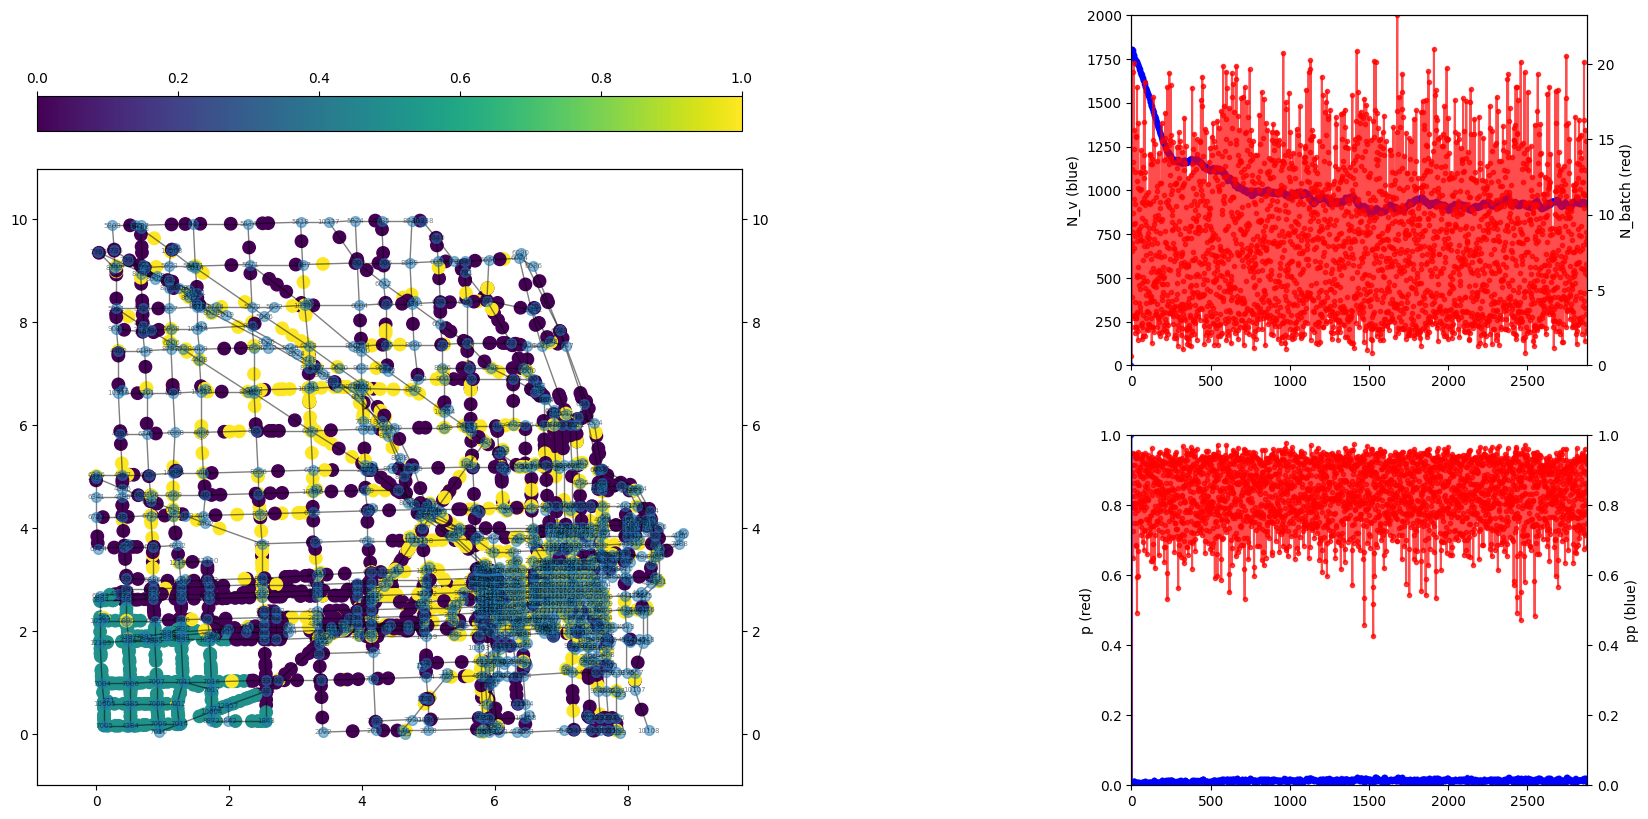

In [15]:
# marking the x-axis and y-axis
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)
ax0 = ax.twinx()
ax0.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax0.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)

ax2 = fig.add_subplot(233)
ax2.set_ylabel('N_v (blue)')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax4 = fig.add_subplot(236)
ax4.set_ylabel('p (red)')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_ylim([0, 1])

# plt.tight_layout()

nx.draw_networkx(G, pos=pos, ax=ax0, node_size=50, font_size=5, alpha=0.5)

color = np.ones(N) * 0.5
scat = ax.scatter(np.random.randint(6, size=N), np.random.randint(6, size=N), s=80, c=color, vmin=0, vmax=1)
fig.colorbar(scat, ax=ax, location='top')
line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)


while c < 100000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)
    
    if c%match_period==0:
        matched_batches, matched_rider_IDs = virtual_plat.match(idle_rider_IDs, rider_set)
    
    num_matched_cust = matched_batches.size
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = 1
    try:
        pp = len(matched_rider_IDs) / len(idle_rider_IDs)
    except:
        pp = 1
    t1 = time.time()
    # move
#     rider_set = rider.move_rider(rider_set, t_resolution, matched_rider_IDs, matched_batches, dec_var)
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set
    print(time.time() - t1)
    
    x_axis.append(c)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    
    
    if c%5==0:
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        ax4.set_ylim([0, 1])
        line5.set_data(x_axis, pp_set)
        ax5.set_ylim([0, 1])

        ax2.set_xlim([0, c])
        ax3.set_xlim([0, c])
        ax4.set_xlim([0, c])
        ax5.set_xlim([0, c])

        display.clear_output(wait=True)
        display.display(plt.gcf()) 
    

    c += 1
    